In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from src.paths import PREPROCESSED_DATA_DIR
from src.features import aggregate_columns_with_lag

In [3]:
data_train = pd.read_pickle(PREPROCESSED_DATA_DIR / 'preprocessed_train.pkl')

df_weather = pd.read_pickle(PREPROCESSED_DATA_DIR / 'clean_weather.pkl').set_index(
    'Date')

In [4]:
print(f'Train columns: {data_train.columns.to_list()}')
print(f'Weather columns: {df_weather.columns.to_list()}')

Train columns: ['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'Dayofyear', 'Week', 'Month', 'Year', 'WnvPresent', 'Tmax_1', 'Tmin_1', 'Tavg_1', 'DewPoint_1', 'WetBulb_1', 'PrecipTotal_1', 'Tmax_2', 'Tmin_2', 'Tavg_2', 'DewPoint_2', 'WetBulb_2', 'PrecipTotal_2']
Weather columns: ['Tmax_1', 'Tmin_1', 'Tavg_1', 'DewPoint_1', 'WetBulb_1', 'PrecipTotal_1', 'Tmax_2', 'Tmin_2', 'Tavg_2', 'DewPoint_2', 'WetBulb_2', 'PrecipTotal_2']


### Adding lagged and aggregated weather features

In [5]:
df_agg = aggregate_columns_with_lag(
    df_weather, 
    lag_range=(1, 15, 3), 
    window_range=(1,10,3), 
    agg_func='mean'
)
df_agg.head()

,Tmax_1_mean_l1_w1,Tmin_1_mean_l1_w1,Tavg_1_mean_l1_w1,DewPoint_1_mean_l1_w1,WetBulb_1_mean_l1_w1,PrecipTotal_1_mean_l1_w1,Tmax_2_mean_l1_w1,Tmin_2_mean_l1_w1,Tavg_2_mean_l1_w1,DewPoint_2_mean_l1_w1,...,Tavg_1_mean_l13_w7,DewPoint_1_mean_l13_w7,WetBulb_1_mean_l13_w7,PrecipTotal_1_mean_l13_w7,Tmax_2_mean_l13_w7,Tmin_2_mean_l13_w7,Tavg_2_mean_l13_w7,DewPoint_2_mean_l13_w7,WetBulb_2_mean_l13_w7,PrecipTotal_2_mean_l13_w7
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-20,80.0,56.0,68.0,39.0,53.0,0.00,80.0,56.0,68.0,37.0,...,59.428571,40.428571,50.000000,0.000429,72.428571,50.000000,61.285714,40.428571,50.428571,0.000143
2007-05-21,69.0,43.0,56.0,40.0,44.0,0.07,69.0,44.0,57.0,41.0,...,59.571429,41.428571,50.857143,0.000429,71.857143,51.142857,61.571429,41.285714,51.285714,0.000286
2007-05-22,80.0,44.0,62.0,50.0,56.0,0.00,79.0,46.0,63.0,50.0,...,62.142857,43.857143,53.142857,0.019000,74.142857,54.000000,64.142857,43.857143,53.571429,0.003143
2007-05-23,87.0,55.0,71.0,46.0,58.0,0.00,87.0,60.0,74.0,44.0,...,64.142857,45.571429,54.857143,0.019000,76.428571,55.571429,66.000000,45.571429,55.142857,0.003143
2007-05-24,89.0,60.0,75.0,49.0,61.0,0.00,89.0,66.0,78.0,48.0,...,64.571429,45.714286,55.000000,0.018857,75.714286,55.285714,65.571429,45.857143,55.285714,0.003143


In [6]:
df_agg.columns

Index(['Tmax_1_mean_l1_w1', 'Tmin_1_mean_l1_w1', 'Tavg_1_mean_l1_w1',
       'DewPoint_1_mean_l1_w1', 'WetBulb_1_mean_l1_w1',
       'PrecipTotal_1_mean_l1_w1', 'Tmax_2_mean_l1_w1', 'Tmin_2_mean_l1_w1',
       'Tavg_2_mean_l1_w1', 'DewPoint_2_mean_l1_w1',
       ...
       'Tavg_1_mean_l13_w7', 'DewPoint_1_mean_l13_w7', 'WetBulb_1_mean_l13_w7',
       'PrecipTotal_1_mean_l13_w7', 'Tmax_2_mean_l13_w7', 'Tmin_2_mean_l13_w7',
       'Tavg_2_mean_l13_w7', 'DewPoint_2_mean_l13_w7', 'WetBulb_2_mean_l13_w7',
       'PrecipTotal_2_mean_l13_w7'],
      dtype='object', length=180)

In [7]:
data_train = pd.merge(data_train, df_agg.reset_index(), on='Date')

### Feature selection

In [8]:
data_train.head()

,Date,Species,Trap,Latitude,Longitude,Dayofyear,Week,Month,Year,WnvPresent,...,Tavg_1_mean_l13_w7,DewPoint_1_mean_l13_w7,WetBulb_1_mean_l13_w7,PrecipTotal_1_mean_l13_w7,Tmax_2_mean_l13_w7,Tmin_2_mean_l13_w7,Tavg_2_mean_l13_w7,DewPoint_2_mean_l13_w7,WetBulb_2_mean_l13_w7,PrecipTotal_2_mean_l13_w7
0,2007-07-02,1.0,T002,41.954690,-87.800991,183,27,7,2007,0,...,77.285714,58.285714,65.714286,0.123,88.142857,68.571429,78.428571,58.428571,65.857143,0.158714
1,2007-07-02,2.0,T002,41.954690,-87.800991,183,27,7,2007,0,...,77.285714,58.285714,65.714286,0.123,88.142857,68.571429,78.428571,58.428571,65.857143,0.158714
2,2007-07-02,1.0,T015,41.974089,-87.824812,183,27,7,2007,0,...,77.285714,58.285714,65.714286,0.123,88.142857,68.571429,78.428571,58.428571,65.857143,0.158714
3,2007-07-02,1.0,T045,41.921600,-87.666455,183,27,7,2007,0,...,77.285714,58.285714,65.714286,0.123,88.142857,68.571429,78.428571,58.428571,65.857143,0.158714
4,2007-07-02,2.0,T045,41.921600,-87.666455,183,27,7,2007,0,...,77.285714,58.285714,65.714286,0.123,88.142857,68.571429,78.428571,58.428571,65.857143,0.158714


In [9]:
data_train_0 = data_train[data_train.WnvPresent==0].groupby(
    ['Trap', 'Year', 'Month']).sample(frac=0.15, random_state=42)
data_train_1 = data_train[data_train.WnvPresent==1]
data_train_undersampled = pd.concat([data_train_0, data_train_1])

data_train_undersampled.drop(['Date', 'Month', 'Year', 'Trap'], axis=1, inplace=True)

In [10]:
data_train_undersampled.shape, data_train_undersampled.WnvPresent.mean()

((1613, 198), np.float64(0.3397396156230626))

In [11]:
labels = data_train_undersampled.pop('WnvPresent')

In [19]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression

classifier = LinearRegression()
sfs_forward = SequentialFeatureSelector(
    classifier,
    n_features_to_select=5,
    direction='forward',
    # scoring='roc_auc',
    n_jobs=-1
).fit(data_train_undersampled[df_agg.columns], labels)

In [20]:
# data_train_undersampled.columns[sfs_forward.get_support()]
data_train_selected = data_train_undersampled.drop(df_agg.columns[~sfs_forward.get_support()], axis=1)

In [28]:
df_agg.columns[sfs_forward.get_support()]

Index(['DewPoint_1_mean_l1_w4', 'PrecipTotal_2_mean_l7_w1',
       'Tmin_1_mean_l10_w1', 'DewPoint_1_mean_l10_w1', 'Tavg_2_mean_l13_w7'],
      dtype='object')

In [23]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

param_grid = {
    'n_estimators': [100],
    'max_depth': [4, 5, 6],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [1, 10],
    'gamma': [0, 0.5],
    'colsample_bytree': [0.8],
    'min_child_weight': [1, 3]
}

xgb = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
model = GridSearchCV(
    param_grid=param_grid,
    estimator=xgb,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

model.fit(data_train_selected, labels)
best_model = model.best_estimator_


Fitting 15 folds for each of 72 candidates, totalling 1080 fits


In [24]:
print(f'Best_model params: {model.best_params_}')
print(f'Best score: {round(model.best_score_, 4)}')

Best_model params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 10}
Best score: 0.8023


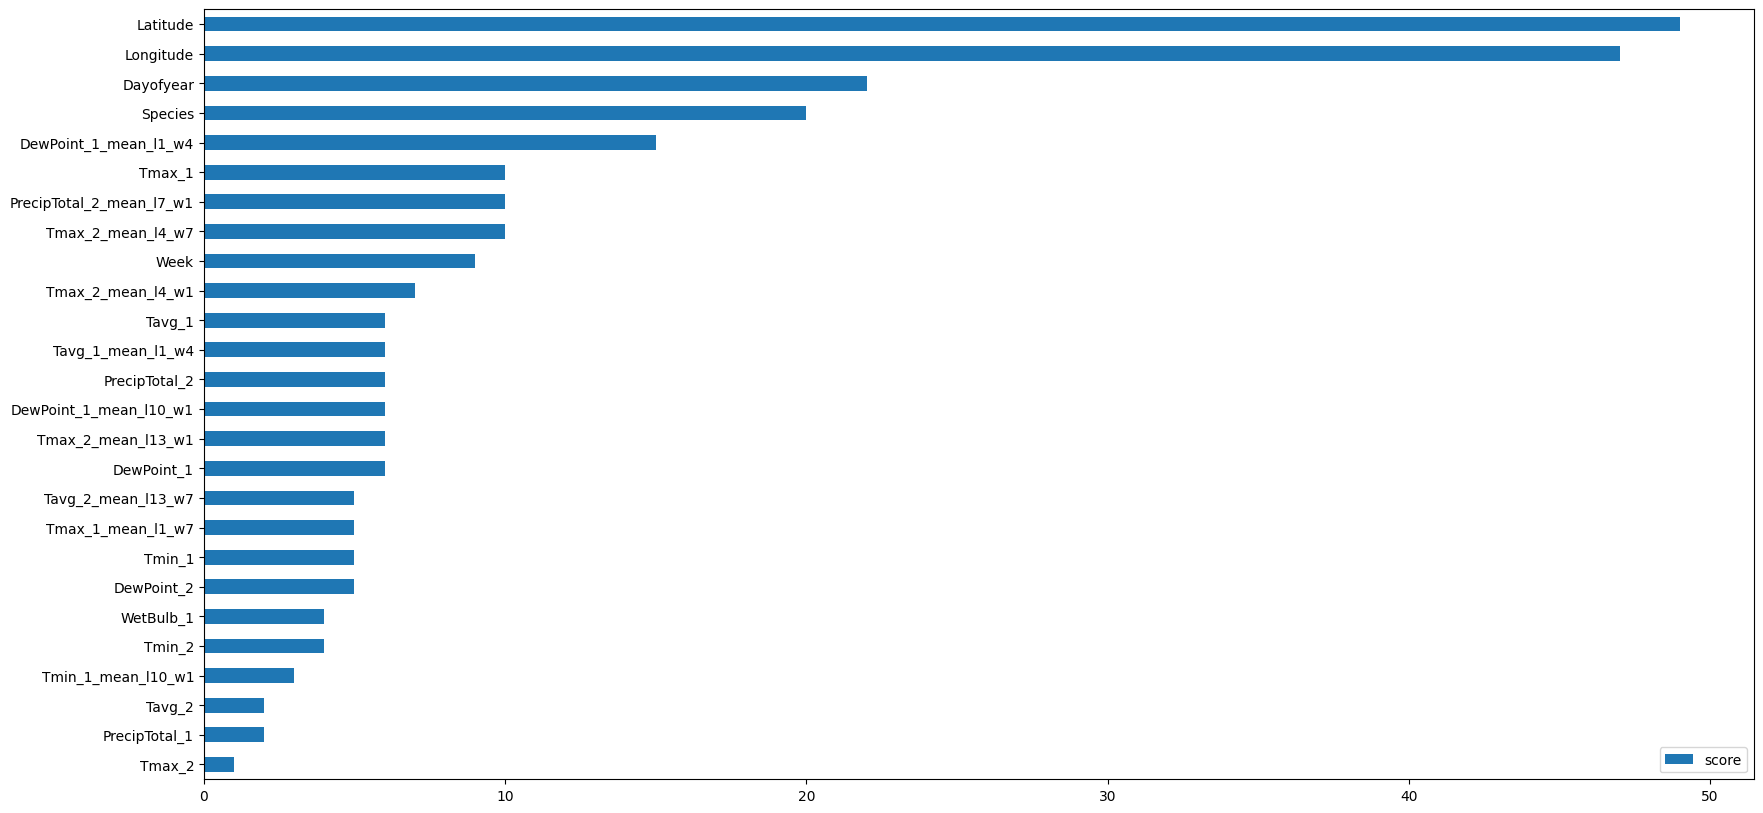

In [18]:
feature_important = best_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values("score")
data.plot(kind='barh', figsize = (20,10));